In [1]:
import pandas as pd
from pandas.core import datetools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette("bright", 10)
% matplotlib inline
import statsmodels.api as sm
import sqlite3
import tweepy
from os import path
from PIL import Image
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  


### GATHERING DATA

#### IMAGE PREDICTIONS

In [2]:
import requests
from PIL import Image
from io import BytesIO
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [3]:
# Save .tsv to file.
with open("image_predictions.tsv", mode = 'wb') as file:
    file.write(r.content)

In [4]:
# Read file and view first few rows.
image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
image_predictions.shape

(2075, 12)

In [6]:
# Find count of true positives and true negatives for p1
p1_true = image_predictions.query('p1_dog == True').count()[0]
p1_false = image_predictions.query('p1_dog == False').count()[0]
p1_true, p1_false

(1532, 543)

In [7]:
# Find count of true positives and true negatives for p2
p2_true = image_predictions.query('p2_dog == True').count()[0]
p2_false = image_predictions.query('p2_dog == False').count()[0]
p2_true, p2_false

(1553, 522)

In [8]:
# Find count of true positives and true negatives for p3
p3_true = image_predictions.query('p3_dog == True').count()[0]
p3_false = image_predictions.query('p3_dog == False').count()[0]
p3_true, p3_false

(1499, 576)

#### TWITTER ARCHIVE

In [9]:
# Read twitter archive file and view first few rows
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
twitter_archive.shape

(2356, 17)

#### TWITTER API

In [11]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

In [12]:
# This is the resulting data from twitter_api.py.

# Downloading it from the link on the Project Details page.

lines=[]
with open('tweet-json.txt','rt') as file:
    for line in file:
        lines.append(line)

In [13]:
# Extracting required data from each line.
f=[]
for line in lines:
    g=[]
    k=line.find('id_str')
    s=line[k+10:k+28]
    g.append(s)
    k=line.find("retweet_count")
    s=line[k+16:k+20]
    g.append(s)
    k=line.find('favorite_count')
    s=line[k+17:k+22]
    g.append(s)
    f.append(g)

In [14]:
# Converting the above extracted data into a pandas dataframe.
api_data=pd.DataFrame(f,columns=['tweet_id','retweet_count','favorite_count'])

In [15]:
api_data.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


#### ASSESSING 

In [16]:
# View and assess data
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [17]:
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1909,852912242202992640,https://pbs.twimg.com/media/C9YnKK3VoAAxn1E.jpg,1,Great_Dane,0.783765,True,Rhodesian_ridgeback,0.114147,True,English_foxhound,0.046440,True
532,676864501615042560,https://pbs.twimg.com/media/CWS0q8iU8AE2Srr.jpg,1,Chesapeake_Bay_retriever,0.371146,True,water_buffalo,0.099596,False,Weimaraner,0.048968,True
989,707969809498152960,https://pbs.twimg.com/media/CdM2xRpXEAUsR4k.jpg,1,toy_poodle,0.908491,True,miniature_poodle,0.082652,True,teddy,0.005786,False
268,670811965569282048,https://pbs.twimg.com/media/CU8z65IUEAQBc4q.jpg,1,basset,0.994090,True,Walker_hound,0.003973,True,beagle,0.001406,True
1080,718234618122661888,https://pbs.twimg.com/media/CfeukpmW4AEGjOE.jpg,1,malamute,0.370152,True,Siberian_husky,0.356398,True,Eskimo_dog,0.271042,True


In [18]:
# Get number of columns and rows
image_predictions.shape

(2075, 12)

In [19]:
# Get sum of duplicated entries
sum(image_predictions.duplicated())

0

In [20]:
image_predictions.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [21]:
image_predictions.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
Staffordshire_bullterrier     20
German_shepherd               20
Siberian_husky                20
web_site                      19
Cardigan                      19
Shetland_sheepdog             18
beagle                        18
Maltese_dog                   18
teddy                         18
Eskimo_dog                    18
Shih-Tzu                      17
Lakeland_terrier              17
Rottweiler                    17
kuvasz                        16
Italian_greyhound             16
          

In [22]:
image_predictions.p2.value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
Chesapeake_Bay_retriever           41
French_bulldog                     41
toy_poodle                         37
cocker_spaniel                     34
miniature_poodle                   33
Siberian_husky                     33
beagle                             28
collie                             27
Pembroke                           27
Eskimo_dog                         27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
chow                               20
malinois                           20
Samoyed                            20
toy_terrier                        20
miniature_pinscher                 20
Norwegian_elkhound                 19
Boston_bull                        19
Staffordshir

In [23]:
image_predictions.p3.value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
Staffordshire_bullterrier         32
chow                              32
cocker_spaniel                    31
beagle                            31
toy_poodle                        29
Pekinese                          29
Pomeranian                        29
Pembroke                          27
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
Cardigan                          23
pug                               23
basenji                           21
toy_terrier                       20
bull_mastiff                      20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
b

In [24]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [25]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [26]:
image_predictions.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

### END

In [27]:
# View and assess data
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [28]:
# Get table shape
twitter_archive.shape

(2356, 17)

In [29]:
# Get summary info
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [30]:
twitter_archive.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Lucy          11
Cooper        11
Penny         10
Lola          10
Tucker        10
Winston        9
Bo             9
Sadie          8
the            8
Buddy          7
Bailey         7
an             7
Daisy          7
Toby           7
Milo           6
Dave           6
Scout          6
Rusty          6
Oscar          6
Bella          6
Koda           6
Jax            6
Stanley        6
Jack           6
Leo            6
Sunny          5
            ... 
Beckham        1
Tassy          1
Molly          1
Furzey         1
Evy            1
Ronduh         1
Ralphie        1
Blakely        1
Strudel        1
Chubbs         1
Marty          1
Lizzie         1
Chaz           1
Dido           1
Napolean       1
Scruffers      1
Iggy           1
Pinot          1
Tupawc         1
Lambeau        1
Holly          1
Tater          1
Monster        1
Sage           1
Lance          1
Mookie         1
Asher          1
Kara          

In [31]:
# Get summary statistics
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [32]:
# Find null values
twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [33]:
# Get duplicated count
sum(twitter_archive.duplicated())

0

In [34]:
# Lets check if there are any denominators greater or less than 10
not_10_denom = twitter_archive.query('rating_denominator != 10')
not_10_denom

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [35]:
# Lets get the count of not_10_denom
not_10_denom.count()[0]

23

In [36]:
twitter_archive.rating_numerator.value_counts().head()

12    558
11    464
10    461
13    351
9     158
Name: rating_numerator, dtype: int64

In [37]:
# Lets look for the highest numerator
twitter_archive.rating_numerator.max()

1776

In [38]:
# Lets look for lowest numerator
twitter_archive.rating_numerator.min()

0

### END

In [39]:
# View and assess data
api_data.head(1)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467


In [40]:
api_data.tail()

,tweet_id,retweet_count,favorite_count
2349,666049248165822465,"41,","111,"
2350,666044226329800704,"147,","311,"
2351,666033412701032449,"47,","128,"
2352,666029285002620928,"48,","132,"
2353,666020888022790149,"532,","2535,"


In [41]:
# Get table info summary
api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null object
favorite_count    2354 non-null object
dtypes: object(3)
memory usage: 55.2+ KB


In [42]:
#check for null values
api_data.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

In [43]:
api_data.shape

(2354, 3)

In [44]:
# Check for duplicate column names in all tables
columns = pd.Series(list(twitter_archive) + 
    list(image_predictions) + list(api_data))
columns[columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

In [45]:
row_count_archive = twitter_archive.shape[0]

In [46]:
row_count_image = image_predictions.shape[0]

### END

QUALITY

image_predictions table

- p1, p2, p3 column entries are not uniformly in lower or upper case
- Column names for p1, p2, p3 not very descriptive
- tweet_id is integer should be string- same for other tables
- best prediction column is string instead of categorical

twitter_archive

- tweet_id is integer not string.
- timestamp is an object not timestamp
- In name column some names have None while others are prepositions like a, an, the
- Denominators that are not 10 and outliers in numerators


api_data
- Columns retweet_count and favorite_count are object instead of integers
- Some entries in retweet_count and favorite_count have comma after them and quotation marks.

TIDINESS

image_predictions table

- Choose 1 prediction to use

twitter_archive

- Columns doggo, floofer, pupper, and puppo should be one column instead of 4 
- Some columns that are irrelevant to the analysis are in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp

api_data

- merge api data, image predictions and twitter archive into one dataframe





### CLEANING

In [47]:
# Make copies of all dataframes
image_clean = image_predictions.copy()
archive_clean = twitter_archive.copy()
api_clean = api_data.copy()

### image_clean

QUALITY

image_predictions table

- p1, p2, p3 table contents are not uniformly in lower or upper case
- Column names for p1, p2, p3 not very descriptive
- tweet_id is integer should be string- same for other tables
- best prediction column is string instead of categorical

TIDINESS

image_predictions table

- Choose 1 prediction to use

In [48]:
image_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**Define:**

Capitalize dog breed name in P1, P2 and P3

**Code**

In [49]:
# Capitalize breed names in P1
image_clean.p1 = image_clean.p1.str.capitalize()

In [50]:
# Capitalize breed names in P2
image_clean.p2 = image_clean.p2.str.capitalize()

In [51]:
# Capitalize breed names in P3
image_clean.p3 = image_clean.p2.str.capitalize()

**Test**

In [52]:
image_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Collie,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Miniature_pinscher,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,Malinois,0.138584,True,Malinois,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Redbone,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Rottweiler,0.154629,True


**Define**

Change tweet_id from interger to string using astype

**Code**

In [53]:
image_clean.tweet_id = image_clean.tweet_id.astype(str)

**Test**

In [54]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


**Define**

Column p1 was chosen as the best prediction from the descriptive statistics summary. Use rename to change p1 column name

**Code**

In [55]:
image_clean.rename(columns = {'img_num': 'image_count', 
                               'p1': 'best_prediction', 
                               'p1_conf': 'confidence', 
                               'p1_dog': 'dog_or_not'}, inplace = True)

**Test**

In [56]:
image_clean.head(1)

,tweet_id,jpg_url,image_count,best_prediction,confidence,dog_or_not,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Collie,0.061428,True


In [57]:
image_predictions.p3_conf.mean()

0.060324168618106515

**Define**
Drop columns p2, p2_conf, p2_dog, p3, p3_conf, p3_dog using drop function

**Code**

In [58]:
image_clean.drop(['p2', 'p2_conf', 'p2_dog', 'p3', 
                  'p3_conf', 'p3_dog'], inplace = True, axis = 1)

**Test**

In [59]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 6 columns):
tweet_id           2075 non-null object
jpg_url            2075 non-null object
image_count        2075 non-null int64
best_prediction    2075 non-null object
confidence         2075 non-null float64
dog_or_not         2075 non-null bool
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 83.2+ KB


**Define**

Change the best prediction column to categorical using astype

**Code**

In [60]:
image_clean.best_prediction = image_clean.best_prediction.astype('category')

**Test**

In [61]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 6 columns):
tweet_id           2075 non-null object
jpg_url            2075 non-null object
image_count        2075 non-null int64
best_prediction    2075 non-null category
confidence         2075 non-null float64
dog_or_not         2075 non-null bool
dtypes: bool(1), category(1), float64(1), int64(1), object(2)
memory usage: 84.0+ KB


In [62]:
image_clean.best_prediction.value_counts()

Golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
Pug                           57
Chow                          44
Samoyed                       43
Toy_poodle                    39
Pomeranian                    38
Cocker_spaniel                30
Malamute                      30
French_bulldog                26
Miniature_pinscher            23
Chesapeake_bay_retriever      23
Seat_belt                     22
Siberian_husky                20
German_shepherd               20
Staffordshire_bullterrier     20
Cardigan                      19
Web_site                      19
Teddy                         18
Eskimo_dog                    18
Maltese_dog                   18
Shetland_sheepdog             18
Beagle                        18
Lakeland_terrier              17
Rottweiler                    17
Shih-tzu                      17
Kuvasz                        16
Italian_greyhound             16
          

**Define**

Create data frame for dogs only using query

**Code**

In [63]:
dogs_only = image_clean.query('dog_or_not == True')
dogs_only.head(3)

,tweet_id,jpg_url,image_count,best_prediction,confidence,dog_or_not
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True


**Test**

In [64]:
dogs_only.best_prediction.value_counts().head(8)

Golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
Pug                    57
Chow                   44
Samoyed                43
Toy_poodle             39
Name: best_prediction, dtype: int64

#### END

### archive_clean

QUALITY

twitter_archive

- tweet_id should be string.
- timestamp is an object not timestamp
- In name column some names have None while others are prepositions like a, an, the
- Denominators that are not 10 and outliers in numerators


TIDINESS
- Columns doggo, floofer, pupper, and puppo should be one column instead of 4 
- Some columns that are irrelevant to the analysis are in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp


**Define**

Change tweet_id column from integer to string using astype


**Code**

In [65]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)

**Test**

In [66]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

**Define**

Convert timestamp column from object type to timestamp using

**Code**

In [67]:
archive_clean.timestamp =  pd.to_datetime(archive_clean['timestamp'])

**Test**

In [68]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](

In [69]:
archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


**Define**

- Replace the word None with NaN
- Make a list of most common prepositions such as a, an, and, the and replace them with NaN

**Code**

In [70]:
# Replace None with NaN
archive_clean.name = archive_clean.name.replace('None','NaN')

In [71]:
# Create list of most common prepositions
prepositions = ['O', 'a', 'about', 'above', 'after', 'again', 
             'against', 'all', 'all', 'am', 'an', 'an', 'and', 
             'any', 'are', 'as', 'at', 'at', 'be', 'because', 
             'been', 'before', 'being', 'below', 'between', 
             'both', 'but', 'by', 'by', 'can', 'did', 'do', 
             'does', 'doing', 'don', 'down', 'during', 'each', 
             'few', 'for', 'from', 'further', 'had', 'has', 
             'have', 'having', 'he', 'her', 'here', 'hers', 
             'herself', 'him', 'himself', 'his', 'how', 'i', 
             'if', 'in', 'into', 'is', 'it', 'its', 'itself', 
             'just', 'just', 'life', 'light', 'me', 'more', 
             'most', 'my', 'my', 'myself', 'no', 'nor', 'not', 
             'not', 'now', 'of', 'off', 'old', 'on', 'once', 
             'only', 'or', 'other', 'our', 'ours', 'ourselves', 
             'out', 'over', 'own', 'quite', 's', 'same', 'she', 
             'should', 'so', 'some', 'space', 'such', 
             't', 'than', 'that', 'the', 'the', 'their', 'theirs', 
             'them', 'themselves', 'then', 'there', 'these', 'they', 
             'this', 'this', 'those', 'through', 'to', 'too', 'under', 
             'until', 'up', 'very', 'very', 'was', 'we', 'were', 
             'what', 'when', 'where', 'which', 'while', 'who', 
             'whom', 'why', 'will', 'with', 'within', 'without', 'you', 'your', 'yours', 
             'yourself', 'yourselves']

In [72]:
# Create a list of prepositions
prepositions = set(prepositions)

In [73]:
# Write to disk to save
with open('prepositions.txt', 'w') as f:
    for word in prepositions:
        f.write(word + '\n')

In [74]:
# Confirm it it works and then sort
with open('prepositions.txt', 'r') as f:
    prepositions = [line.rstrip('\n') for line in f]
prepositions.sort()

In [75]:
# Replace the prepositions with NaNs.
archive_clean.name.replace(prepositions, np.nan, inplace = True)

**Test**

In [76]:
archive_clean.name.value_counts()

NaN             745
Charlie          12
Cooper           11
Lucy             11
Oliver           11
Lola             10
Tucker           10
Penny            10
Winston           9
Bo                9
Sadie             8
Daisy             7
Buddy             7
Toby              7
Bailey            7
Bella             6
Dave              6
Jack              6
Jax               6
Rusty             6
Scout             6
Stanley           6
Oscar             6
Milo              6
Koda              6
Leo               6
Oakley            5
Phil              5
George            5
Finn              5
               ... 
Furzey            1
Evy               1
Kallie            1
Kellogg           1
Eazy              1
Bruiser           1
Pete              1
Chaz              1
Monster           1
Dido              1
Napolean          1
Scruffers         1
Iggy              1
Pinot             1
Strudel           1
Tupawc            1
Holly             1
Tater             1
Sage              1


In [77]:
#archive_clean['rating'] = archive_clean.rating_numerator / archive_clean.rating_denominator

In [78]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [79]:
archive_clean.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

**Define**

- Use query to allow only for denominators should be 10 and numerators should be less than 16

**Code**

In [80]:
archive_clean = archive_clean.query('rating_numerator < 16 and rating_denominator == 10')

**Test**

In [81]:
archive_clean.rating_denominator.value_counts()

10    2323
Name: rating_denominator, dtype: int64

In [82]:
archive_clean.rating_numerator.value_counts()

12    558
11    463
10    461
13    351
9     156
8     102
7      54
14     54
5      37
6      32
3      19
4      15
2       9
1       8
15      2
0       2
Name: rating_numerator, dtype: int64

**Define**

- Drops columns that are not relevant in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, rating_denominator

**Code**

In [83]:
# Drop columns
archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'rating_denominator'], inplace = True, axis = 1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


**Test**

In [84]:
archive_clean.head(0)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo


**Define**

Combine columns doggo, floofer, pupper, and puppo should be one column called dog_stage

**Code**

In [85]:
dog_stage = ['doggo', 'floofer', 'pupper', 'puppo']
def my_dog_stage(stages):
    for stage in stages:
        if stage in dog_stage:
            return stage
        else:
            pass
    return stage

In [86]:
# Combine all dog stages into 1 column 
archive_clean['dog_stage'] = archive_clean[['doggo', 'floofer', 
    'pupper', 'puppo']].apply(my_dog_stage, axis = 1)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [87]:
# Drop columns not needed
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], inplace = True, axis = 1)
archive_clean.dog_stage = archive_clean.dog_stage.astype('category')

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [88]:
# Convert data type to category 

archive_clean.dog_stage = archive_clean.dog_stage.astype('category')

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [89]:
# Capitalize stages in dog_stage
archive_clean.dog_stage = archive_clean.dog_stage.str.capitalize()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


**Test**

In [90]:
archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,None
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,NaN,None
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,Jax,None
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,NaN,None
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,Zoey,None
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,Cassie,Doggo


**Define**

Replace None with NaN in dog_stage column

**Code**

In [91]:
# Replace None with NaNs.
archive_clean.dog_stage = archive_clean.dog_stage.replace('None','NaN')

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


**Test**

In [92]:
archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,NaN
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,NaN,NaN
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,Jax,NaN
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,NaN,NaN
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,Zoey,NaN
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,Cassie,Doggo


#### END

### api_data

QUALITY

api_data

- Columns retweet_count and favorite_count are object instead of integers
- Some entries in retweet_count and favorite_count have comma after them and quotation marks.


TIDINESS

**Define**

- Extract numerical values from the affected columns

**Code**

In [93]:
# Extract integers from retweet count column
api_clean.retweet_count = api_clean.retweet_count.str.extract('(\d+)')

In [94]:
# Extract integers from favorite count column
api_clean.favorite_count = api_clean.favorite_count.str.extract('(\d+)')

**Test**

In [95]:
api_clean

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,1671,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


**Define**

Convert retweet and favorite count data type to integer

**Code**

In [96]:
api_clean[["retweet_count", "favorite_count"]] = api_clean[["retweet_count", "favorite_count"]].apply(pd.to_numeric)

**Test**

In [97]:
api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


**TIDINESS**

**Define**
Combine all 3 tables into 1 using merge and drop any columns that will not be relevant to the analysis

**Code**

In [98]:
# Merge all 3 tables into 1
twitter_archive_master = archive_clean.merge(api_clean, on = 'tweet_id')
twitter_archive_master = twitter_archive_master.merge(image_clean, 
  on = 'tweet_id', how = 'left')

In [99]:
# Drop columns
twitter_archive_master.drop(['source', 'text', 'expanded_urls'], inplace = True, axis = 1)

**Test**

In [100]:
twitter_archive_master.head(2)

,tweet_id,timestamp,rating_numerator,name,dog_stage,retweet_count,favorite_count,jpg_url,image_count,best_prediction,confidence,dog_or_not
0,892420643555336193,2017-08-01 16:23:56,13,Phineas,NaN,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,0.097049,False
1,892177421306343426,2017-08-01 00:17:27,13,Tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True


**Define**
Convert image_count from float to integer using astype

**Code**

In [101]:
twitter_archive_master.image_count = twitter_archive_master[["image_count"]].apply(pd.to_numeric)

**Test**

In [102]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 0 to 2320
Data columns (total 12 columns):
tweet_id            2321 non-null object
timestamp           2321 non-null datetime64[ns]
rating_numerator    2321 non-null int64
name                2228 non-null object
dog_stage           2321 non-null object
retweet_count       2321 non-null int64
favorite_count      2321 non-null int64
jpg_url             2050 non-null object
image_count         2050 non-null float64
best_prediction     2050 non-null category
confidence          2050 non-null float64
dog_or_not          2050 non-null object
dtypes: category(1), datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 235.1+ KB


### Save All Files

**Define**

Store all files in csv format

In [103]:
# Save files.
twitter_archive_master.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)
archive_clean.to_csv('archive_clean.csv', encoding='utf-8', index=False)
image_clean.to_csv('image_clean.csv', encoding='utf-8', index=False)
api_clean.to_csv('api_clean.csv', encoding='utf-8', index=False)

**Test**

### ANALYSE AND VISUALIZE TWITTER DATA

Analyze

- Find the most popular dog name and its relationship with retweet and favorite count
- Relationship between retweet and favorite count
- Do dogs with the highest rating get the most retweet and favorite
- Does posting more image lead to more retweets and favoriting
- Has the accounts tweeting rate increased or decreased over time
- compare the ratings, fav and retweet of dogs and not dogs
- word map

In [104]:
twitter_archive_master.head()

,tweet_id,timestamp,rating_numerator,name,dog_stage,retweet_count,favorite_count,jpg_url,image_count,best_prediction,confidence,dog_or_not
0,892420643555336193,2017-08-01 16:23:56,13,Phineas,NaN,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,0.097049,False
1,892177421306343426,2017-08-01 00:17:27,13,Tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True
2,891815181378084864,2017-07-31 00:18:03,12,Archie,NaN,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True
3,891689557279858688,2017-07-30 15:58:51,13,Darla,NaN,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Paper_towel,0.170278,False
4,891327558926688256,2017-07-29 16:00:24,12,Franklin,NaN,9774,41048,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,0.555712,True


In [105]:
twitter_archive_master.describe()

,rating_numerator,retweet_count,favorite_count,image_count,confidence
count,2321.000000,2321.000000,2321.000000,2050.000000,2050.000000
mean,10.702714,2145.754847,9409.901336,1.203902,0.594492
std,2.176567,2109.009403,11834.724863,0.562696,0.271312
min,0.000000,0.000000,52.000000,1.000000,0.044333
25%,10.000000,624.000000,2046.000000,1.000000,0.363272
50%,11.000000,1350.000000,4489.000000,1.000000,0.588620
75%,12.000000,2996.000000,12518.000000,1.000000,0.843799
max,15.000000,9907.000000,95450.000000,4.000000,1.000000


The follwing were observed from the descriptive statistics summary above:

1. The maximum rating_numerator is 15 and minimum is 0
2. The retweet and favorite count also vary vastly between maximum and minimum.
3. There is a minimum of 1 picture to a dog and a maximum of 4. We have 2050 images compared to 2321 entries.


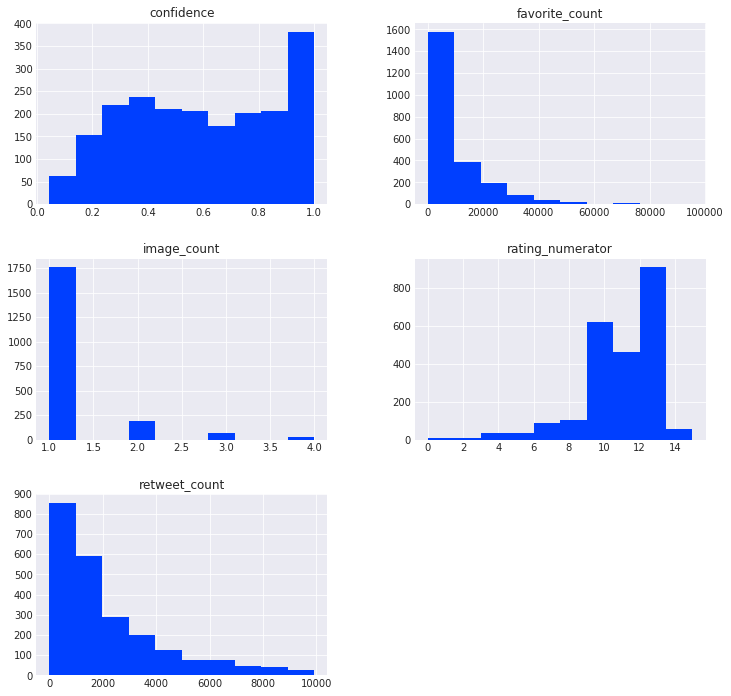

In [106]:
twitter_archive_master.hist(figsize=(12,12));

In [107]:
#sns.distplot('rating_numerator');

From the historgram the following were observed:

1. The retweet and favorite are right skewed
2. The rating numerator is left skewed with most dogs having a rating of 10 and above. 
3. The rating numerators are mostly between 10 and 14

In [108]:
q=twitter_archive_master.groupby(['name']).mean()[['rating_numerator']].sort_values('rating_numerator', ascending=False)

Find the most popular dog name and its relationship with retweet and favorite count. Or are the most popular dog names also those with the most retweet and favorites

In [109]:
most_popular_name = twitter_archive_master.name.value_counts().head(6)
most_popular_name

NaN        721
Charlie     12
Cooper      11
Lucy        11
Oliver      11
Lola        10
Name: name, dtype: int64

The top 5 most popular dog names are the above. Nan is discarded because it means no name was provided for that dog.

Find the top 10 rated dog breeds

In [110]:
# Get only dogs
only_dogs = twitter_archive_master.query('dog_or_not == True')
only_dogs

,tweet_id,timestamp,rating_numerator,name,dog_stage,retweet_count,favorite_count,jpg_url,image_count,best_prediction,confidence,dog_or_not
1,892177421306343426,2017-08-01 00:17:27,13,Tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True
2,891815181378084864,2017-07-31 00:18:03,12,Archie,NaN,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True
4,891327558926688256,2017-07-29 16:00:24,12,Franklin,NaN,9774,41048,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,0.555712,True
5,891087950875897856,2017-07-29 00:08:17,13,NaN,NaN,3261,20562,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,Chesapeake_bay_retriever,0.425595,True
6,890971913173991426,2017-07-28 16:27:12,13,Jax,NaN,2158,12041,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1.0,Appenzeller,0.341703,True
7,890729181411237888,2017-07-28 00:22:40,13,NaN,NaN,1671,56848,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2.0,Pomeranian,0.566142,True
8,890609185150312448,2017-07-27 16:25:51,13,Zoey,NaN,4429,28226,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1.0,Irish_terrier,0.487574,True
9,890240255349198849,2017-07-26 15:59:51,14,Cassie,Doggo,7711,32467,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1.0,Pembroke,0.511319,True
10,890006608113172480,2017-07-26 00:31:25,13,Koda,NaN,7624,31166,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1.0,Samoyed,0.957979,True
11,889880896479866881,2017-07-25 16:11:53,13,Bruno,NaN,5156,28268,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,1.0,French_bulldog,0.377417,True


In [111]:
top10_rating = only_dogs.groupby(['best_prediction']).mean()[['rating_numerator']].sort_values(['rating_numerator'], ascending=False)[0:10]
top10_rating

,rating_numerator
best_prediction,
Saluki,12.500000
Tibetan_mastiff,12.400000
Briard,12.333333
Border_terrier,12.142857
Silky_terrier,12.000000
Giant_schnauzer,12.000000
Standard_schnauzer,12.000000
Irish_setter,11.833333
Eskimo_dog,11.777778


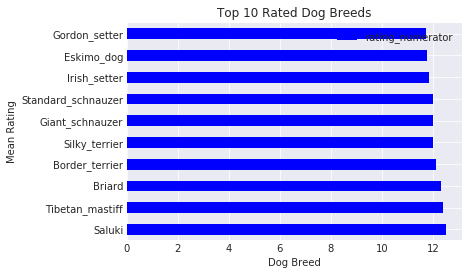

In [112]:
top10_rating.plot(kind="barh", color="blue")
plt.xlabel("Dog Breed")
plt.ylabel("Mean Rating")
plt.title("Top 10 Rated Dog Breeds")
plt.show();

The top rated dog is Saluki but he difference between the top 10 is not very significant. The rating were mostly arbitrary by the owners    

Compare ratings with favorite count

In [113]:
# Get favorite count for each rating
twitter_archive_master.groupby(['rating_numerator']).sum()[['favorite_count']].sort_values(['favorite_count'], ascending=False)

,favorite_count
rating_numerator,
13,6975342
12,6529666
11,3540059
10,2121243
14,1417729
9,395842
8,281444
7,170707
5,137693


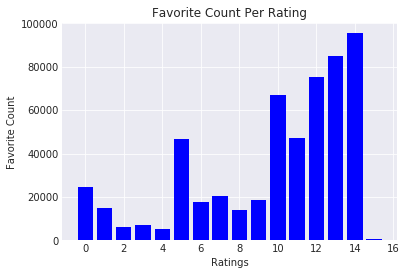

In [114]:
# Plot Bar Chart
plt.bar("rating_numerator", "favorite_count", data = twitter_archive_master, color = "blue")
plt.xlabel("Ratings")
plt.ylabel("Favorite Count")
plt.title("Favorite Count Per Rating")
plt.show();

In [115]:
#sns.barplot(x="rating_numerator", y="retweet_count", data=twitter_archive_master, saturation=1);

In [116]:
#ax = sns.barplot(x="rating_numerator", y="favorite_count", data=twitter_archive_master, saturation=1, errcolor='100')

Lets look at the relationship between retweet counts and favorite count

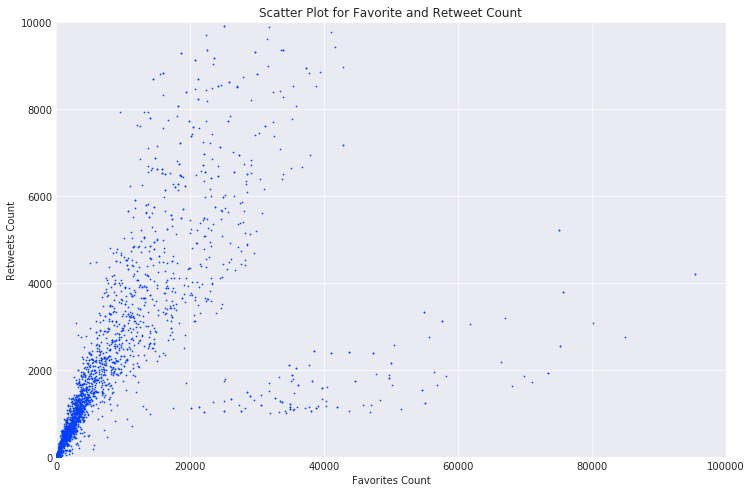

In [117]:
# Scatter plot for favorite and retweet count.
plt.figure(figsize=(12, 8))
plt.xlim(0, 100000)
plt.ylim(0, 10000)
plt.xlabel('Favorites Count')
plt.ylabel('Retweets Count')
plt.plot(twitter_archive_master.favorite_count, 
    twitter_archive_master.retweet_count, linestyle='', 
     marker='o', markersize=0.7)
plt.title('Scatter Plot for Favorite and Retweet Count');

There is clearly a strong relationship between retweet and favorite count. Lets examine the relationship further by fitting a regression line

In [118]:
# Fit a linear regression model
twitter_archive_master['intercept'] = 1
lm = sm.OLS(twitter_archive_master['retweet_count'], twitter_archive_master[['intercept', 'favorite_count']])

In [119]:
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     1075.
Date:                Wed, 15 Apr 2020   Prob (F-statistic):          5.20e-194
Time:                        17:36:44   Log-Likelihood:                -20616.
No. Observations:                2321   AIC:                         4.124e+04
Df Residuals:                    2319   BIC:                         4.125e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       1202.0959     46.246     25.994      0.000    1111.409    1292.783
favorite_count     0.1003      0.003     32.783      0.000       0.094       0.106
==============================================================================
Omnibus:                      245.327   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              751.722
Skew:                           0.542   Prob(JB):                    5.83e-164
Kurtosis:                       5.569   Cond. No.                     1.93e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For every 1 unit increase in favorite count we will predict that the retweet count will increase by 0.1003
The p-value also shows that the favorite_ count is statistically significant in predicting the retweet count

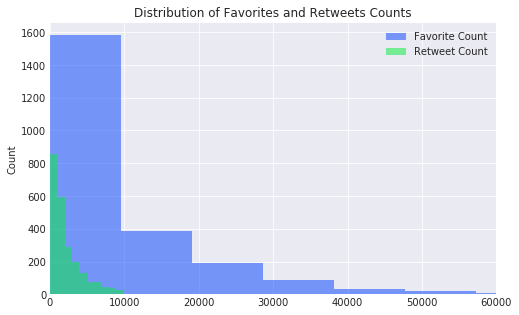

In [120]:
# Histograms of favorites and retweets
plt.figure(figsize=(8, 5))
plt.xlim(0, 60000)
plt.ylabel('Count')
plt.hist(twitter_archive_master.favorite_count, alpha=.5, label='Favorite Count')
plt.hist(twitter_archive_master.retweet_count, alpha=.5, label='Retweet Count')
plt.title('Distribution of Favorites and Retweets Counts')
plt.legend();

The distribution for favorite and retweet count follow the same pattern

compare the ratings, fav and retweet of dogs and not dogs

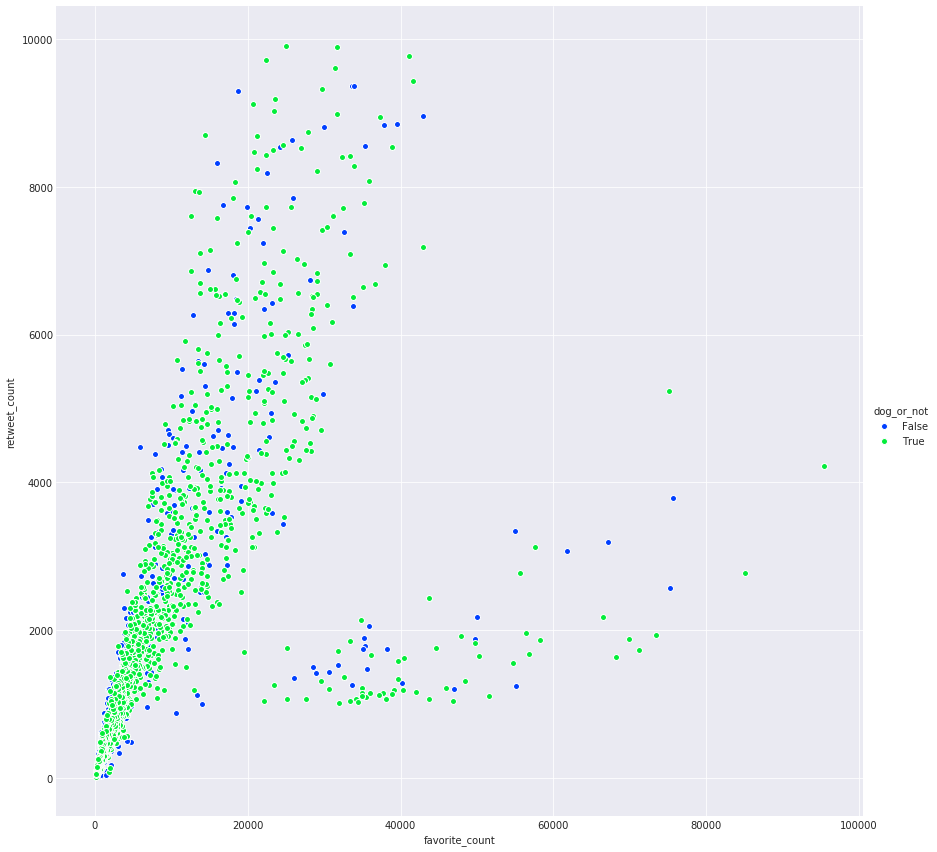

In [121]:
sns.pairplot(x_vars="favorite_count",  y_vars="retweet_count", hue="dog_or_not", size=12, data=twitter_archive_master);

In [122]:
#ab = sns.barplot(x="favorite_count", y="retweet_count", data=twitter_archive_master)

In [123]:
# Plot scatter for overall_rating, attacking work rate and defensive work rate
#ax1 = twitter_archive_master.plot(kind='scatter', x='retweet_count', y='favorite_count', color='r')

Lets see the correlation between the different columns

In [124]:
twitter_archive_master.corr()

,rating_numerator,retweet_count,favorite_count,image_count,confidence,intercept
rating_numerator,1.000000,0.333686,0.400061,0.191741,0.093866,NaN
retweet_count,0.333686,1.000000,0.562742,0.184211,0.111238,NaN
favorite_count,0.400061,0.562742,1.000000,0.149986,0.084056,NaN
image_count,0.191741,0.184211,0.149986,1.000000,0.204039,NaN
confidence,0.093866,0.111238,0.084056,0.204039,1.000000,NaN
intercept,NaN,NaN,NaN,NaN,NaN,NaN


The following were observed from the correlation table:
1. The highest correlation is between retweets and favorite count
2. There is a moderate correlation between rating numerator and favorite count

Lets now examine the relationship of rating numerator and favorite count by fitting linear model

In [125]:
# Fit a linear regression model
twitter_archive_master['intercept'] = 1
lm2 = sm.OLS(twitter_archive_master['favorite_count'], twitter_archive_master[['intercept', 'rating_numerator']])

In [126]:
results2 = lm2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     441.9
Date:                Wed, 15 Apr 2020   Prob (F-statistic):           6.15e-90
Time:                        17:36:45   Log-Likelihood:                -24859.
No. Observations:                2321   AIC:                         4.972e+04
Df Residuals:                    2319   BIC:                         4.973e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept        -1.387e+04   1130.194    -12.273      0.000   -1.61e+04   -1.17e+04
rating_numerator  2175.2663    103.481     21.021      0.000    1972.340    2378.192
==============================================================================
Omnibus:                     1283.795   Durbin-Watson:                   1.423
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11193.125
Skew:                           2.497   Prob(JB):                         0.00
Kurtosis:                      12.529   Cond. No.                         55.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For every 1 unit increase in rating numerator we will predict that the favorite count will increase by 2175.27 The p-value also shows that the rating numerator is statistically significant in predicting the rating

Now lets see how retweets, favorites and ratings have fared over time

In [127]:
twitter_archive_master.head(2)

,tweet_id,timestamp,rating_numerator,name,dog_stage,retweet_count,favorite_count,jpg_url,image_count,best_prediction,confidence,dog_or_not,intercept
0,892420643555336193,2017-08-01 16:23:56,13,Phineas,NaN,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,0.097049,False,1
1,892177421306343426,2017-08-01 00:17:27,13,Tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,1


In [128]:
# Get number tweets per day
day_tweets = twitter_archive_master.groupby(by=twitter_archive_master['timestamp'].dt.date).count().tweet_id
day_tweets #= day_tweets[['timestamp', 'tweet_id']]

timestamp
2015-11-15     3
2015-11-16    24
2015-11-17    15
2015-11-18    18
2015-11-19    23
2015-11-20    22
2015-11-21    17
2015-11-22    20
2015-11-23    21
2015-11-24    18
2015-11-25    21
2015-11-26    13
2015-11-27    17
2015-11-28    26
2015-11-29    25
2015-11-30    17
2015-12-01    24
2015-12-02    14
2015-12-03    18
2015-12-04    14
2015-12-05    13
2015-12-06    16
2015-12-07    21
2015-12-08    21
2015-12-09    17
2015-12-10    18
2015-12-11    16
2015-12-12    16
2015-12-13    12
2015-12-14    10
              ..
2017-07-02     1
2017-07-03     2
2017-07-04     2
2017-07-05     1
2017-07-06     2
2017-07-07     2
2017-07-08     1
2017-07-09     2
2017-07-10     2
2017-07-11     2
2017-07-12     2
2017-07-13     3
2017-07-14     1
2017-07-15     4
2017-07-16     2
2017-07-17     1
2017-07-18     2
2017-07-19     3
2017-07-20     1
2017-07-22     2
2017-07-23     1
2017-07-24     2
2017-07-25     3
2017-07-26     2
2017-07-27     1
2017-07-28     2
2017-07-29     2
2017

In [129]:
# Get number of tweets per month
month_tweets = twitter_archive_master.groupby(pd.TimeGrouper(key='timestamp', freq='M')).count().tweet_id
month_tweets

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


timestamp
2015-11-30    300
2015-12-31    385
2016-01-31    189
2016-02-29    123
2016-03-31    134
2016-04-30     58
2016-05-31     59
2016-06-30     96
2016-07-31    103
2016-08-31     74
2016-09-30     82
2016-10-31     87
2016-11-30     88
2016-12-31     69
2017-01-31     93
2017-02-28     85
2017-03-31     67
2017-04-30     58
2017-05-31     56
2017-06-30     59
2017-07-31     54
2017-08-31      2
Freq: M, Name: tweet_id, dtype: int64

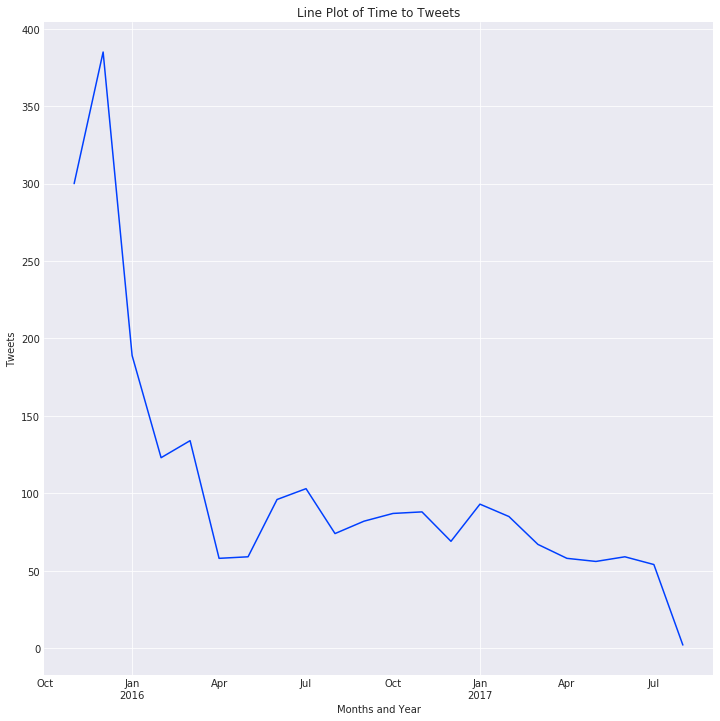

In [130]:
month_tweets.plot(kind='line', figsize=(12,12))
plt.xlabel('Months and Year')
plt.ylabel('Tweets')
plt.title('Line Plot of Time to Tweets');

From the above line chart we can see that number of tweets have dropped over time. From a high of 385 on 2015-12-31 to a low of just 2 tweets on 2017-08-31.

Now lets check how retweets and favorites have fared over time

In [131]:
# Get favorites per month
month_favorites = twitter_archive_master.groupby(pd.Grouper(key='timestamp', freq='M')).sum().favorite_count
month_favorites

timestamp
2015-11-30     361289
2015-12-31    1360977
2016-01-31     748746
2016-02-29     502005
2016-03-31     618797
2016-04-30     278541
2016-05-31     364401
2016-06-30     736244
2016-07-31     853887
2016-08-31     833310
2016-09-30    1033430
2016-10-31    1222703
2016-11-30    1282768
2016-12-31    1099417
2017-01-31    1747862
2017-02-28    1571611
2017-03-31    1330321
2017-04-30    1148463
2017-05-31    1460068
2017-06-30    1539098
2017-07-31    1673157
2017-08-31      73286
Freq: M, Name: favorite_count, dtype: int64

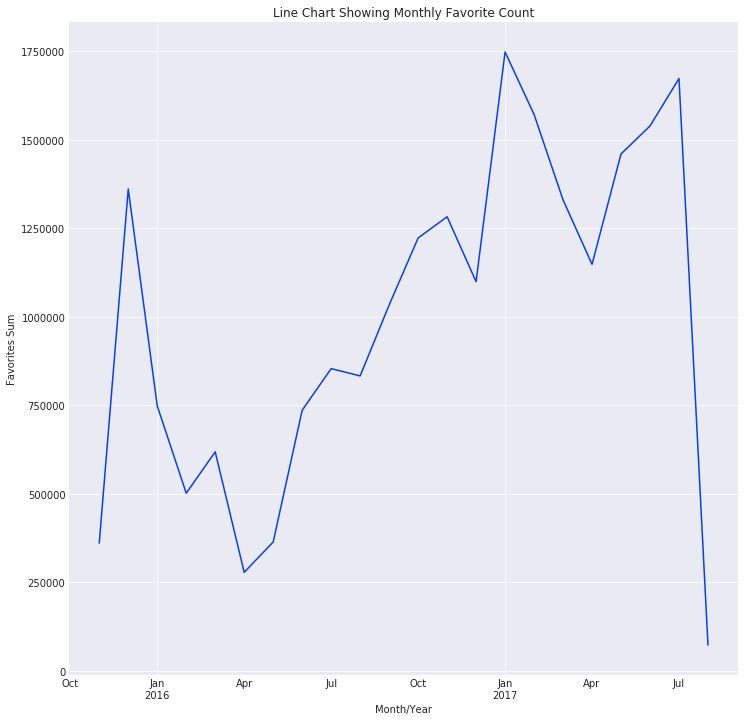

In [132]:
# Plot monthly favorite count agaist time
month_favorites.plot(kind='line', figsize=(12,12))
plt.xlabel('Month/Year')
plt.ylabel('Favorites Sum')
plt.title('Line Chart Showing Monthly Favorite Count');

The favorites sum were on upward trajectory at the begining before dipping from January to April 2016. It then picked up and continued its upward trajecory until July 2017

In [133]:
month_retweets = twitter_archive_master.groupby(pd.Grouper(key='timestamp', freq='M')).sum().retweet_count
month_retweets

timestamp
2015-11-30    140590
2015-12-31    450598
2016-01-31    243605
2016-02-29    153965
2016-03-31    205349
2016-04-30    101767
2016-05-31    115751
2016-06-30    233859
2016-07-31    243708
2016-08-31    200110
2016-09-30    273114
2016-10-31    327059
2016-11-30    324540
2016-12-31    249534
2017-01-31    319013
2017-02-28    256697
2017-03-31    237600
2017-04-30    205463
2017-05-31    227849
2017-06-30    219065
2017-07-31    235694
2017-08-31     15367
Freq: M, Name: retweet_count, dtype: int64

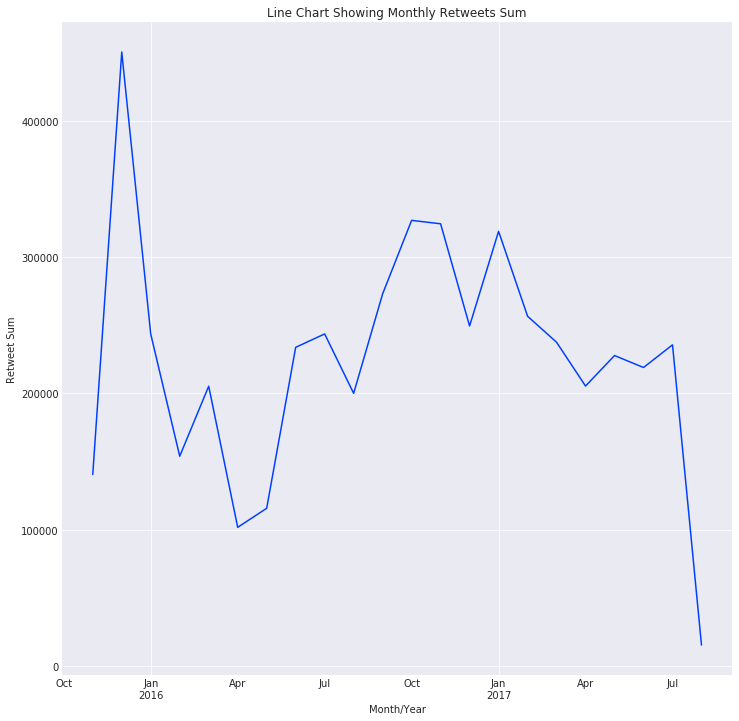

In [134]:
month_retweets.plot(kind='line', figsize=(12,12))
plt.xlabel('Month/Year')
plt.ylabel('Retweet Sum')
plt.title('Line Chart Showing Monthly Retweets Sum');

The retweet line graph follows the same pattern as the favorite count as expected

Lets combine the tweets and retweet monthly graph to see how they interact. To do this we have to divide the monthly tweets by 1000

In [135]:
# Divide monthly retweet counts by 1000
retweet_1000 = month_retweets/1000

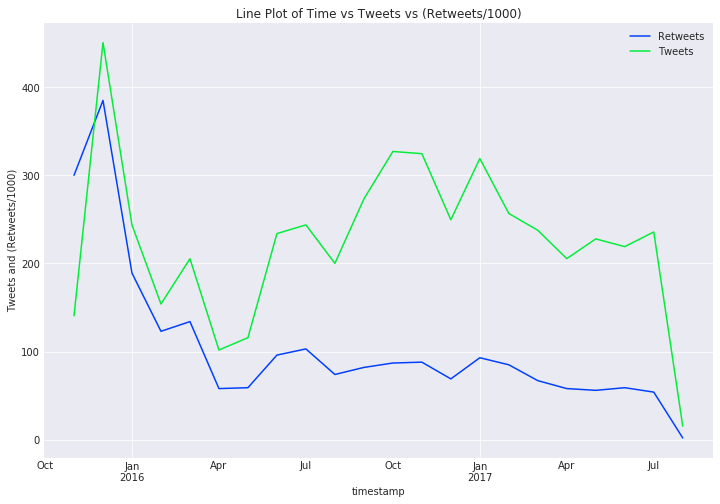

In [136]:
plt.figure(figsize=(12, 8)) 
plt.xlabel('Year and Month')
plt.ylabel('Tweets and (Retweets/1000)')
month_tweets.plot(kind='line')
retweet_1000.plot(kind='line')
plt.legend(('Retweets', 'Tweets'));
plt.title('Line Plot of Time vs Tweets vs (Retweets/1000)');

From the above we can see that the beginning the tweets were following the same pattern as the retweets. However later the number of original tweets from the dog ratings account decreased but retweets were still increasing.

In [137]:
month_ratings = twitter_archive_master.groupby(pd.Grouper(key='timestamp', freq='M')).mean().rating_numerator
month_ratings

timestamp
2015-11-30     8.943333
2015-12-31     9.602597
2016-01-31    10.259259
2016-02-29    10.065041
2016-03-31    10.582090
2016-04-30    10.706897
2016-05-31    10.898305
2016-06-30    10.395833
2016-07-31    10.922330
2016-08-31    11.054054
2016-09-30    11.207317
2016-10-31    11.758621
2016-11-30    11.681818
2016-12-31    11.869565
2017-01-31    12.204301
2017-02-28    12.047059
2017-03-31    12.417910
2017-04-30    12.362069
2017-05-31    12.696429
2017-06-30    12.610169
2017-07-31    12.648148
2017-08-31    13.000000
Freq: M, Name: rating_numerator, dtype: float64

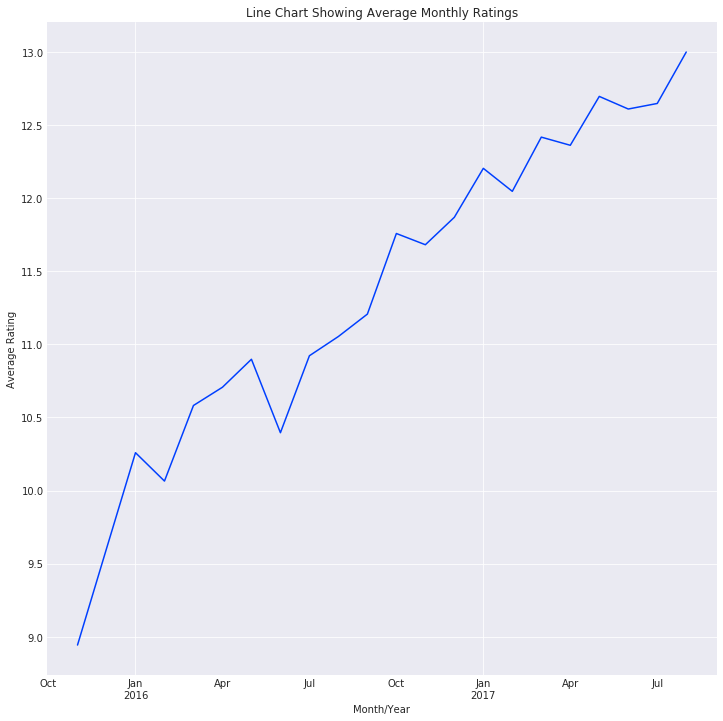

In [138]:
month_ratings.plot(kind='line', figsize=(12,12))
plt.xlabel('Month/Year')
plt.ylabel('Average Rating')
plt.title('Line Chart Showing Average Monthly Ratings');

Its crytal clear that the ratings are changing over time. Ratings are increasing month on month

Lets see how ratings compare for each dog stage

In [139]:
# Get counts for all dog stages
ds_count = twitter_archive_master.dog_stage.value_counts()
ds_count

NaN        1943
Pupper      243
Doggo        97
Puppo        29
Floofer       9
Name: dog_stage, dtype: int64

In [140]:
ds_count = ds_count[1:5]
ds_count

Pupper     243
Doggo       97
Puppo       29
Floofer      9
Name: dog_stage, dtype: int64

In [141]:
ds_count.sum()

378

In [142]:
stg_per = ds_count/ds_count.sum() * 100
stg_per

Pupper     64.285714
Doggo      25.661376
Puppo       7.671958
Floofer     2.380952
Name: dog_stage, dtype: float64

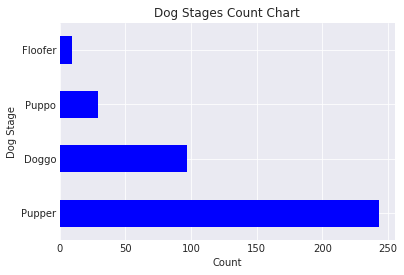

In [143]:
# Plot bar chart to visualize dog stage count
ds_count.plot(kind="barh", color="blue")
plt.xlabel('Count')
plt.ylabel('Dog Stage')
plt.title('Dog Stages Count Chart');

Pupper stage has the highest number of dogs with 243

In [144]:
ds_rating = twitter_archive_master.groupby('dog_stage').mean().rating_numerator
ds_rating

dog_stage
Doggo      11.804124
Floofer    11.888889
NaN        10.611426
Pupper     10.781893
Puppo      12.103448
Name: rating_numerator, dtype: float64

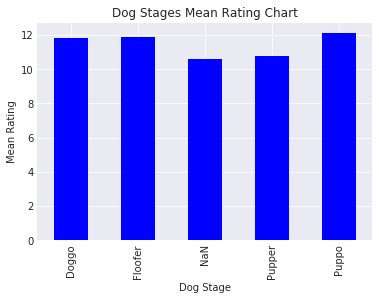

In [145]:
# Plot bar chart to visualize dog stage ratings
ds_rating.plot(kind="bar", color="blue")
plt.xlabel('Dog Stage')
plt.ylabel('Mean Rating')
plt.title('Dog Stages Mean Rating Chart');

Puppo stage has the highest mean rating while Pupper has the lowest. There isnt much rating mean difference between all the stages.

Lets get the top 10 dog breeds with the most favorite and retweet count

In [146]:
# Top 10 dog breeds with most favorite count
dog_fav = twitter_archive_master.query('dog_or_not == True')
dog_fav

,tweet_id,timestamp,rating_numerator,name,dog_stage,retweet_count,favorite_count,jpg_url,image_count,best_prediction,confidence,dog_or_not,intercept
1,892177421306343426,2017-08-01 00:17:27,13,Tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,1
2,891815181378084864,2017-07-31 00:18:03,12,Archie,NaN,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,1
4,891327558926688256,2017-07-29 16:00:24,12,Franklin,NaN,9774,41048,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,0.555712,True,1
5,891087950875897856,2017-07-29 00:08:17,13,NaN,NaN,3261,20562,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,Chesapeake_bay_retriever,0.425595,True,1
6,890971913173991426,2017-07-28 16:27:12,13,Jax,NaN,2158,12041,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1.0,Appenzeller,0.341703,True,1
7,890729181411237888,2017-07-28 00:22:40,13,NaN,NaN,1671,56848,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2.0,Pomeranian,0.566142,True,1
8,890609185150312448,2017-07-27 16:25:51,13,Zoey,NaN,4429,28226,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1.0,Irish_terrier,0.487574,True,1
9,890240255349198849,2017-07-26 15:59:51,14,Cassie,Doggo,7711,32467,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1.0,Pembroke,0.511319,True,1
10,890006608113172480,2017-07-26 00:31:25,13,Koda,NaN,7624,31166,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1.0,Samoyed,0.957979,True,1
11,889880896479866881,2017-07-25 16:11:53,13,Bruno,NaN,5156,28268,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,1.0,French_bulldog,0.377417,True,1


In [147]:
# Top 10 dog breeds with most favorite count
top10_fav = dog_fav.groupby('best_prediction').sum().favorite_count.sort_values(ascending=False)[0:10]
top10_fav

best_prediction
Golden_retriever      1888078
Labrador_retriever    1164351
Pembroke               994755
Chihuahua              660529
Samoyed                616347
Chow                   441848
Cocker_spaniel         386387
French_bulldog         369593
Pug                    355569
Cardigan               308755
Name: favorite_count, dtype: int64

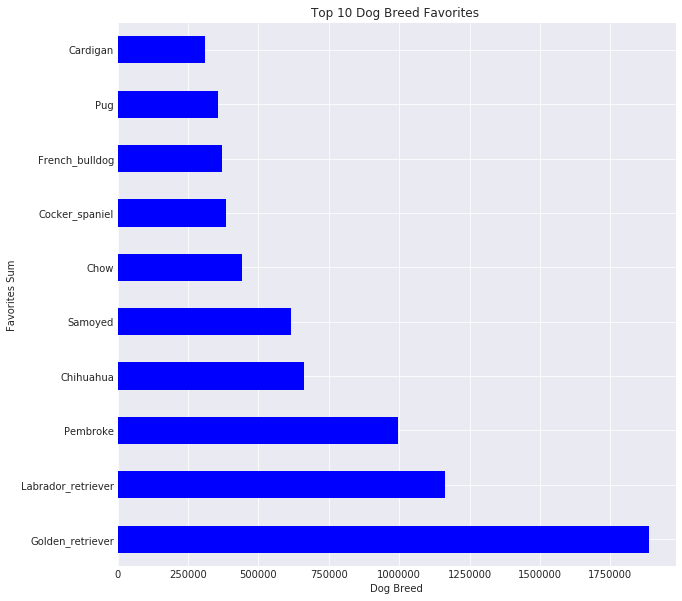

In [148]:
# Plot bar chart to visualize dog stage ratings
top10_fav.plot(kind="barh", color="blue", figsize=(10,10))
plt.xlabel('Dog Breed')
plt.ylabel('Favorites Sum')
plt.title('Top 10 Dog Breed Favorites ');

The Golden_retriever is the most favorited dog by a big margin

In [149]:
#df1.where(df1.values==df2.values).notna()

In [150]:
top10_rating = only_dogs.groupby(['best_prediction']).mean()[['rating_numerator']].sort_values(['rating_numerator'], ascending=False)[0:10]
top10_rating

,rating_numerator
best_prediction,
Saluki,12.500000
Tibetan_mastiff,12.400000
Briard,12.333333
Border_terrier,12.142857
Silky_terrier,12.000000
Giant_schnauzer,12.000000
Standard_schnauzer,12.000000
Irish_setter,11.833333
Eskimo_dog,11.777778


Find out if the top 10 favorite are also the top 10 rated Dog Breeds

In [151]:
#top10_fav.where(top10_fav.values==top10_rating.values).notna()

In [152]:
# Check for common entries
#.where(top10_fav.values==top10_rating.values).notna()
top10_fav.isin(top10_rating).value_counts()

False    10
Name: favorite_count, dtype: int64

Non of the top 10 favorite dog breed is also a top 10 rated dog breed

In [153]:
twitter_archive_master.head(2)

,tweet_id,timestamp,rating_numerator,name,dog_stage,retweet_count,favorite_count,jpg_url,image_count,best_prediction,confidence,dog_or_not,intercept
0,892420643555336193,2017-08-01 16:23:56,13,Phineas,NaN,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,0.097049,False,1
1,892177421306343426,2017-08-01 00:17:27,13,Tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,1


Lets look at how days of the week affect retweeting and favoriting

In [154]:
# Lets make a copy of the twitter_archive_master because we might alter it 
tam = twitter_archive_master.copy()

In [155]:
# Get days of the week and add to tam
tam['timestamp'] = pd.to_datetime(tam['timestamp'], format='%Y-%m-%d', errors='ignore')
tam['day_of_week'] = tam['timestamp'].dt.strftime('%A')
tam

,tweet_id,timestamp,rating_numerator,name,dog_stage,retweet_count,favorite_count,jpg_url,image_count,best_prediction,confidence,dog_or_not,intercept,day_of_week
0,892420643555336193,2017-08-01 16:23:56,13,Phineas,NaN,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,0.097049,False,1,Tuesday
1,892177421306343426,2017-08-01 00:17:27,13,Tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,1,Tuesday
2,891815181378084864,2017-07-31 00:18:03,12,Archie,NaN,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,1,Monday
3,891689557279858688,2017-07-30 15:58:51,13,Darla,NaN,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Paper_towel,0.170278,False,1,Sunday
4,891327558926688256,2017-07-29 16:00:24,12,Franklin,NaN,9774,41048,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,0.555712,True,1,Saturday
5,891087950875897856,2017-07-29 00:08:17,13,NaN,NaN,3261,20562,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,Chesapeake_bay_retriever,0.425595,True,1,Saturday
6,890971913173991426,2017-07-28 16:27:12,13,Jax,NaN,2158,12041,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1.0,Appenzeller,0.341703,True,1,Friday
7,890729181411237888,2017-07-28 00:22:40,13,NaN,NaN,1671,56848,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2.0,Pomeranian,0.566142,True,1,Friday
8,890609185150312448,2017-07-27 16:25:51,13,Zoey,NaN,4429,28226,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1.0,Irish_terrier,0.487574,True,1,Thursday
9,890240255349198849,2017-07-26 15:59:51,14,Cassie,Doggo,7711,32467,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1.0,Pembroke,0.511319,True,1,Wednesday


In [156]:
# Lets also get the weekdays and weekend 
tam['is_weekday'] = tam.timestamp.dt.weekday<5
tam.head()

,tweet_id,timestamp,rating_numerator,name,dog_stage,retweet_count,favorite_count,jpg_url,image_count,best_prediction,confidence,dog_or_not,intercept,day_of_week,is_weekday
0,892420643555336193,2017-08-01 16:23:56,13,Phineas,NaN,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,Orange,0.097049,False,1,Tuesday,True
1,892177421306343426,2017-08-01 00:17:27,13,Tilly,NaN,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,1,Tuesday,True
2,891815181378084864,2017-07-31 00:18:03,12,Archie,NaN,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,1,Monday,True
3,891689557279858688,2017-07-30 15:58:51,13,Darla,NaN,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Paper_towel,0.170278,False,1,Sunday,False
4,891327558926688256,2017-07-29 16:00:24,12,Franklin,NaN,9774,41048,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,0.555712,True,1,Saturday,False


In [157]:
# Lets look for the average number of retweets for each day of the week
day_retweet = tam.groupby('day_of_week').mean().retweet_count.sort_values(ascending=False)
day_retweet

day_of_week
Tuesday      2323.861190
Wednesday    2285.621083
Monday       2191.900000
Friday       2129.987692
Saturday     2067.967320
Sunday       1993.628070
Thursday     1967.510903
Name: retweet_count, dtype: float64

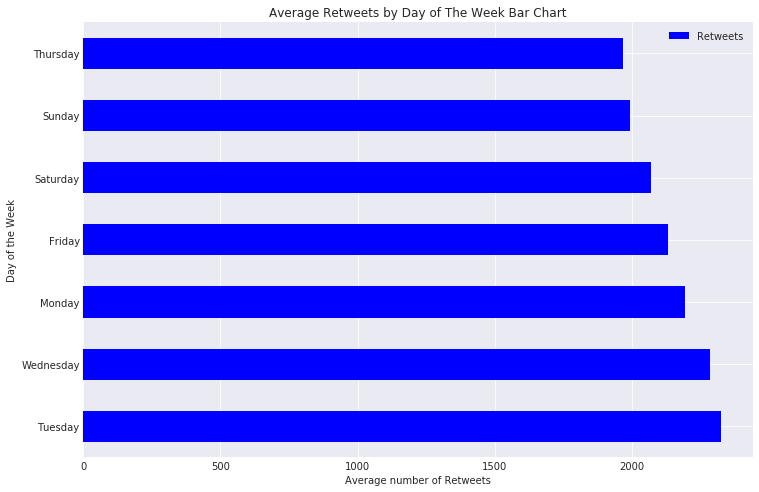

In [158]:
# Plot bar Chart
plt.figure(figsize=(12, 8)) 
day_retweet.plot(kind='barh', color="blue")
plt.xlabel('Average number of Retweets')
plt.ylabel('Day of the Week')
plt.legend(('Retweets', 'Tweets'));
plt.title('Average Retweets by Day of The Week Bar Chart');

Mondays, Tuesdays and Wednesdays have the highest average number of retweets.

In [159]:
# Lets look for the number of retweets on all days
day_fav = tam.groupby('day_of_week').mean().favorite_count.sort_values(ascending=False)
day_fav

day_of_week
Wednesday    11301.470085
Tuesday       9840.566572
Sunday        9698.466667
Friday        9096.772308
Thursday      9073.598131
Monday        8558.252632
Saturday      8217.549020
Name: favorite_count, dtype: float64

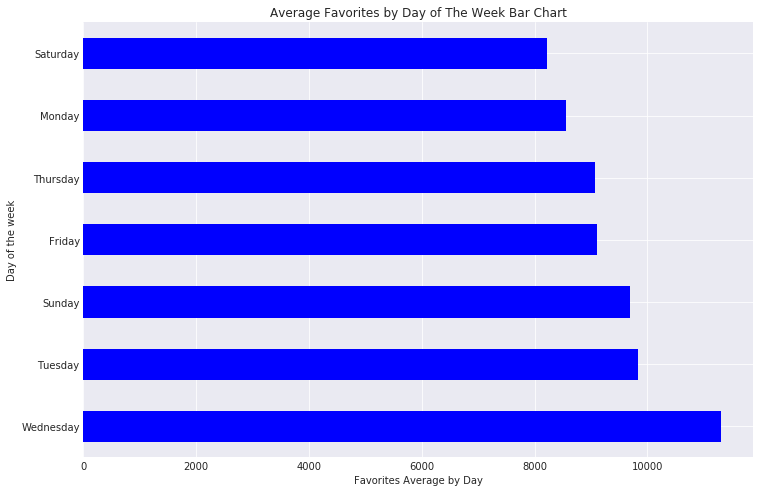

In [160]:
plt.figure(figsize=(12, 8))
day_fav.plot(kind='barh', color="blue")
plt.xlabel('Favorites Average by Day')
plt.ylabel('Day of the week')
plt.title('Average Favorites by Day of The Week Bar Chart');

Highest favorites are on Wednesdays while lowest is on saturday

In [161]:
# How about ratings on days
day_ratings = tam.groupby('day_of_week').mean().rating_numerator
day_ratings

day_of_week
Friday       10.855385
Monday       10.510526
Saturday     10.823529
Sunday       10.540351
Thursday     10.853583
Tuesday      10.742210
Wednesday    10.618234
Name: rating_numerator, dtype: float64

There doesnt seem to be much difference in ratings based on the day of the week. People were generally consistent no matter what day of the week it was.

In [162]:
# Get dog with most and least number of favorites
twitter_archive_master.favorite_count.max()

95450

In [163]:
twitter_archive_master.query('favorite_count == 95450')

,tweet_id,timestamp,rating_numerator,name,dog_stage,retweet_count,favorite_count,jpg_url,image_count,best_prediction,confidence,dog_or_not,intercept
437,819015337530290176,2017-01-11 02:57:27,14,Bo,Doggo,4222,95450,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1.0,Standard_poodle,0.351308,True,1
440,819004803107983360,2017-01-11 02:15:36,14,Bo,Doggo,4222,95450,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1.0,Standard_poodle,0.351308,True,1


Bo is the dog with the highest favorite count. Check out his picture [here](https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg). Very Cute

In [164]:
# Now lets see the dog with the highest retweets
twitter_archive_master.retweet_count.max()

9907

In [165]:
twitter_archive_master.query('retweet_count == 9907')

,tweet_id,timestamp,rating_numerator,name,dog_stage,retweet_count,favorite_count,jpg_url,image_count,best_prediction,confidence,dog_or_not,intercept
456,817181837579653120,2017-01-06 01:31:47,13,NaN,Pupper,9907,25057,https://pbs.twimg.com/ext_tw_video_thumb/81596...,1.0,Tibetan_mastiff,0.506312,True,1
469,815966073409433600,2017-01-02 17:00:46,13,NaN,Pupper,9907,25057,https://pbs.twimg.com/ext_tw_video_thumb/81596...,1.0,Tibetan_mastiff,0.506312,True,1


Time to have some little fun. I will be forming a word cloud based on the words in the original tweets

In [166]:
# Get tweet text
word_pic = archive_clean.text

In [167]:
# Save file
word_pic.to_csv('word.txt', index=False, sep=' ', header=None)

In [168]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

In [169]:
# Read the whole text.
text = open(path.join(d, 'word.txt')).read()

In [170]:
# read the mask / color image taken from
dogs = np.array(Image.open(path.join(d, "dog.jpg")))
stopwords = set(STOPWORDS)
stopwords.add("said")

In [171]:
#wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask,
               #stopwords=stopwords, contour_width=3, contour_color='steelblue')

In [172]:
wc = WordCloud(background_color="white", max_words=2000, mask=dogs,
               stopwords=stopwords, max_font_size=40, random_state=42)

In [ ]:
# generate word cloud
wc.generate(text)

# create coloring from image
image_colors = ImageColorGenerator(dogs)

In [ ]:
# store to file
wc.to_file(path.join(d, "dog.png"))

In [ ]:
# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(dogs, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

### Conclusion

LIMITATIONS

•	WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent."  This shows its not meant to be a rigorous exercise. Ratings, retweets and favorites  are subjective. Its more of a social experiment. 
•	The dog stage column has only 378 entries with 1943 missing. This limits how much you interpret results involving dog stages. 
•	The name column also has a lot of missing values making it difficult to read much meaning into it.

CONCLUSION

The WeRateDogs account really took off and had exponential growth after the initial effort by the owner. The growth looks organic and shows have social media accounts can take a life of their own. So even though the owners are not tweeting as much as they used to, the account still maintains its popularity.
Top rated dogs are not also the most favorited. The Golden and Labrador retriever are the 2 most favorited dogs but do not appear on the top rated 10. Infact non of the top rated is also in the most favorited. It shows the diversity of dog breeds present in the data
Rating changed over time, with monthly averages increasing month on month.
Overall it seems people enjoy rating, retweeting and favoriting dogs on this twitter account. 
